# Master-Part Tables

Work with compositional data where a master entity contains multiple detail records.

In [1]:
import datajoint as dj

schema = dj.Schema('howto_masterpart')
schema.drop(prompt=False)
schema = dj.Schema('howto_masterpart')

[2026-02-19 18:32:09] DataJoint 2.1.1 connected to postgres@postgres:5432


## When to Use Part Tables

Part tables model **compositional** relationships where:

- Parts cannot exist without their master
- Parts are typically queried in the context of their master
- The master-parts unit should be inserted and deleted together

**Good use cases:**

| Master | Part | Why |
|--------|------|-----|
| Session | Trial | Trials only exist within sessions |
| Probe | Electrode | Electrodes are physical parts of probes |
| Video | Frame | Frames are components of videos |
| Segmentation | Cell | Detected cells belong to one segmentation |

**Use regular foreign keys instead when:**

- Entities have independent meaning (e.g., subjects across sessions)
- Entities need to be queried without the parent context
- The relationship is a loose association rather than strict composition

## Define Master and Part Tables

Part tables are nested classes inheriting from `dj.Part`. Use `-> master` to reference the enclosing table:

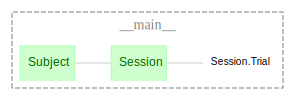

In [2]:
@schema
class Subject(dj.Manual):
    definition = """
    subject_id : varchar(16)
    ---
    species : varchar(32)
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session_idx : int16
    ---
    session_date : date
    """

    class Trial(dj.Part):
        definition = """
        -> master
        trial_idx : int32
        ---
        stimulus : varchar(32)
        response : varchar(32)
        reaction_time : float32
        """

dj.Diagram(schema)

The `-> master` syntax:

- Inherits the master's primary key
- Creates a foreign key constraint
- Enforces that parts cannot exist without their master

**SQL naming:** Part tables use double underscore in the database: `session__trial`

## Insert Master and Parts

Masters must exist before their parts. Use a transaction for atomicity:

In [3]:
# Insert subject first
Subject.insert1({'subject_id': 'M001', 'species': 'Mus musculus'})

# Insert session and trials atomically
with dj.conn().transaction:
    Session.insert1({
        'subject_id': 'M001',
        'session_idx': 1,
        'session_date': '2026-01-20'
    })
    Session.Trial.insert([
        {'subject_id': 'M001', 'session_idx': 1, 'trial_idx': 1, 
         'stimulus': 'A', 'response': 'left', 'reaction_time': 0.35},
        {'subject_id': 'M001', 'session_idx': 1, 'trial_idx': 2, 
         'stimulus': 'B', 'response': 'right', 'reaction_time': 0.42},
        {'subject_id': 'M001', 'session_idx': 1, 'trial_idx': 3, 
         'stimulus': 'A', 'response': 'left', 'reaction_time': 0.28},
    ])

Session.Trial()

subject_id,session_idx,trial_idx,stimulus,response,reaction_time
M001,1,1,A,left,0.35
M001,1,2,B,right,0.42
M001,1,3,A,left,0.28


The transaction ensures both inserts succeed or neither does. If inserting trials fails, the session is rolled back.

## Query and Aggregate Parts

Access parts through the master class:

In [4]:
# All trials
Session.Trial()

subject_id,session_idx,trial_idx,stimulus,response,reaction_time
M001,1,1,A,left,0.35
M001,1,2,B,right,0.42
M001,1,3,A,left,0.28


In [5]:
# Join master and parts to get session info with each trial
Session * Session.Trial

subject_id,session_idx,trial_idx,stimulus,response,reaction_time,session_date
M001,1,1,A,left,0.35,2026-01-20
M001,1,2,B,right,0.42,2026-01-20
M001,1,3,A,left,0.28,2026-01-20


In [6]:
# Aggregate: count trials and compute mean reaction time per session
Session.aggr(
    Session.Trial,
    n_trials='count(trial_idx)',
    mean_rt='avg(reaction_time)'
)

subject_id,session_idx,n_trials,mean_rt
M001,1,3,0.3499999940395355


## Computed Tables with Parts

Computed tables can have parts. In `make()`, insert the master first, then its parts:

In [7]:
@schema
class SessionAnalysis(dj.Computed):
    definition = """
    -> Session
    ---
    n_trials : int32
    mean_rt : float32
    """

    class TrialScore(dj.Part):
        definition = """
        -> master
        -> Session.Trial
        ---
        score : float32
        """

    def make(self, key):
        trials = (Session.Trial & key).to_dicts()
        
        # Insert master
        self.insert1({
            **key,
            'n_trials': len(trials),
            'mean_rt': sum(t['reaction_time'] for t in trials) / len(trials)
        })
        
        # Insert parts
        self.TrialScore.insert([
            {**key, 'trial_idx': t['trial_idx'], 'score': 1.0 / t['reaction_time']}
            for t in trials
        ])

SessionAnalysis.populate()
SessionAnalysis.TrialScore()

subject_id,session_idx,trial_idx,score
M001,1,1,2.857143
M001,1,2,2.3809524
M001,1,3,3.5714285


## Delete Patterns

Deleting from the master cascades to its parts:

In [8]:
# This deletes the session AND all its trials AND computed results
(Session & {'subject_id': 'M001', 'session_idx': 1}).delete(prompt=False)

# Verify parts are gone
len(Session.Trial())

[2026-02-19 18:32:09] Deleting 3 rows from "howto_masterpart"."__session_analysis__trial_score"


[2026-02-19 18:32:09] Deleting 3 rows from "howto_masterpart"."session__trial"


[2026-02-19 18:32:09] Deleting 1 rows from "howto_masterpart"."__session_analysis"


[2026-02-19 18:32:09] Deleting 1 rows from "howto_masterpart"."session"


0

Direct deletion from parts is blocked by default. Use `part_integrity` to control this behavior. See [Delete Data](delete-data.md) for details.

## See Also

- [Define Tables](define-tables.md) — Table definition syntax
- [Insert Data](insert-data.md) — Insertion patterns
- [Delete Data](delete-data.md) — Deletion and part_integrity options
- [Model Relationships](model-relationships.ipynb) — Foreign key patterns
- [Master-Part Specification](../reference/specs/master-part.md) — Full reference

In [9]:
schema.drop(prompt=False)